In [1]:
import numpy as np
import os
import pandas as pd
# import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import json
from collections import OrderedDict
import joblib
import utils.models as model_utils

pygame 2.5.1 (SDL 2.28.2, Python 3.9.17)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Preparation

In [2]:
MODEL_FILEDIR = '/scratch/data/TrojAI/rl-randomized-lavaworld-aug2023/models/'
# MODEL_NUM = 117
OUTPUT_FILEDIR = '/scratch/jialin/rl-randomized-lavaworld-aug2023/extracted_features'
MODEL_SUMMARY_FILEPATH = '/scratch/data/TrojAI/rl-randomized-lavaworld-aug2023/METADATA.csv'
METADATA = pd.read_csv(MODEL_SUMMARY_FILEPATH)

def num_to_model_id(num):
    return 'id-' + str(100000000+num)[1:]

def load_model(model_num):
    model_id = num_to_model_id(model_num)
    model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
    # model_info_fp = model_filepath + '.stats.json'
    model = torch.load(model_filepath)
    # with open(model_info_fp, 'r') as f:
    #     model_info = json.load(f)
    return model

In [3]:
METADATA['poisoned'] = METADATA['ground_truth'] == 'triggered'

In [4]:
METADATA.head()

,split,model_name,model_arch,ground_truth,grid_size,trigger,simple_poison_constant,clean_success_rate,poison_success_rate,poisoned
0,train,id-00000000,FCModel,clean,9,NaN,NaN,1.0,NaN,False


In [5]:
model = load_model(0)

In [6]:
model

{'obs_space': Dict('direction': Box(0, 3, (1,), int64), 'image': Box(0, 255, (3, 7, 7), uint8)),
 'action_space': Discrete(3),
 'linear_embedding_dims': (512, 256),
 'actor_linear_mid_dims': (64, 32),
 'critic_linear_mid_dims': (64, 32),
 'state_dict': OrderedDict([('state_emb.1.weight',
               tensor([[ 0.0459,  0.0276, -0.0733,  ...,  0.0343, -0.0590,  0.0179],
                       [-0.0653,  0.0132, -0.0436,  ..., -0.0078,  0.0210, -0.0028],
                       [-0.0691,  0.0071, -0.0170,  ...,  0.0295,  0.0433, -0.0441],
                       ...,
                       [ 0.0206, -0.0371, -0.0754,  ..., -0.0321, -0.0603,  0.0050],
                       [-0.0846, -0.0133,  0.0473,  ..., -0.0547, -0.0748,  0.0811],
                       [ 0.0472, -0.1533,  0.0136,  ..., -0.0560,  0.0153, -0.0292]])),
              ('state_emb.1.bias',
               tensor([-0.0887, -0.0902, -0.0355, -0.0048, -0.0531, -0.0348, -0.0763,  0.0313,
                       -0.0929, -0.1053,

In [7]:
for k, v in model['state_dict'].items():
    print(f'{k} - {v.shape}')

state_emb.1.weight - torch.Size([512, 147])
state_emb.1.bias - torch.Size([512])
state_emb.3.weight - torch.Size([256, 512])
state_emb.3.bias - torch.Size([256])
actor.0.weight - torch.Size([64, 257])
actor.0.bias - torch.Size([64])
actor.2.weight - torch.Size([32, 64])
actor.2.bias - torch.Size([32])
actor.4.weight - torch.Size([3, 32])
actor.4.bias - torch.Size([3])
critic.0.weight - torch.Size([64, 257])
critic.0.bias - torch.Size([64])
critic.2.weight - torch.Size([32, 64])
critic.2.bias - torch.Size([32])
critic.4.weight - torch.Size([1, 32])
critic.4.bias - torch.Size([1])


In [43]:
rl_model = torch.load('/scratch/data/TrojAI/rl-lavaworld-jul2023-train/models/id-00000000/model-state-dict.pt')

In [11]:
for k, v in rl_model.items():
    print(f'{k} - {v.shape}')

state_emb.0.weight - torch.Size([100, 147])
state_emb.0.bias - torch.Size([100])
state_emb.2.weight - torch.Size([64, 100])
state_emb.2.bias - torch.Size([64])
actor.0.weight - torch.Size([32, 64])
actor.0.bias - torch.Size([32])
actor.2.weight - torch.Size([3, 32])
actor.2.bias - torch.Size([3])
critic.0.weight - torch.Size([32, 64])
critic.0.bias - torch.Size([32])
critic.2.weight - torch.Size([1, 32])
critic.2.bias - torch.Size([1])


### Feature Extraction

In [40]:
def _get_weight_features(model_repr, dim=(), normalize=False):
    weight_features = []
    for backbone_params in model_repr.values():
        # pshape = len(param.shape)
        # if axis is None:
            # axis = tuple(range(-1, -1*(pshape), -1))
        # weight_features += np.max(param, axis= axis, keepdims=True).flatten().tolist()
        # weight_features += np.mean(param, axis= axis, keepdims=True).flatten().tolist()
        # sub = np.mean(param, axis= axis, keepdims=True) - np.median(param, axis= axis, keepdims=True)
        # weight_features += sub.flatten().tolist()
        # weight_features += np.median(param, axis= axis, keepdims=True).flatten().tolist()
        # weight_features += np.sum(np.abs(param), axis= axis, keepdims=True).flatten().tolist()
        if normalize:
            norm = torch.linalg.norm(backbone_params.reshape(backbone_params.shape[0], -1), ord=2)
            backbone_params  = backbone_params/norm
        weight_features += torch.amax(backbone_params, dim=dim).flatten().detach().cpu().tolist()
        weight_features += torch.mean(backbone_params, dim=dim).flatten().detach().cpu().tolist()
        # end_dim = -1*(len(backbone_params.shape) - len(dim)) - 1
        # sub = torch.mean(backbone_params, dim=dim) - torch.median(torch.flatten(backbone_params, start_dim=0, end_dim=end_dim), dim=end_dim)[0]
        # weight_features += sub.flatten().detach().cpu().tolist()
        # weight_features += torch.median(torch.flatten(backbone_params, start_dim=0, end_dim=end_dim), dim=end_dim)[0].flatten().detach().cpu().tolist()
        weight_features += torch.sum(backbone_params, dim=dim).flatten().detach().cpu().tolist()
    return weight_features

def _get_eigen_features(model_repr, ssv_len=100):
    min_shape, params = 1, []
    for param in model_repr.values():
        if len(param.shape) > min_shape:
            reshaped_param = param.reshape(param.shape[0], -1)
            _, singular_values, _ = np.linalg.svd(reshaped_param, False)
            ssv = np.square(singular_values).flatten()
            # params.append(ssv.max().item())
            # params.append(ssv.mean().item())
            # params.append((ssv.mean() - np.median(ssv)).item())
            # params.append(np.median(ssv).item())
            # params.append(ssv.sum().item())
            params.extend(ssv.tolist()[:ssv_len])
    return params

In [13]:
def _get_weight_features(model_repr, axis=None):
    weight_features = []
    for param in model_repr.values():
        pshape = len(param.shape)
        axis = tuple(range(-1, -1*(pshape), -1))
        weight_features += np.max(param, axis= axis).tolist()
        weight_features += np.mean(param, axis= axis).tolist()
        sub = np.mean(param, axis= axis) - np.median(param, axis= axis)
        weight_features += sub.tolist()
        weight_features += np.median(param, axis= axis).tolist()
        weight_features += np.sum(np.abs(param), axis= axis).tolist()
    return weight_features

def _get_eigen_features(model_repr, ssv_len=100):
    min_shape, params = 1, []
    for param in model_repr.values():
        if len(param.shape) > min_shape:
            reshaped_param = param.reshape(param.shape[0], -1)
            _, singular_values, _ = np.linalg.svd(reshaped_param, False)
            ssv = np.square(singular_values).flatten()
            # params.append(ssv.max().item())
            # params.append(ssv.mean().item())
            # params.append((ssv.mean() - np.median(ssv)).item())
            # params.append(np.median(ssv).item())
            # params.append(ssv.sum().item())
            params.extend(ssv.tolist()[:ssv_len])
    return params

In [14]:
METADATA['model_arch']

0    FCModel
Name: model_arch, dtype: object

In [22]:
metadata

,model_name,arch,poison,K1,ground_truth,clean_success,poison_success
0,id-00000000,BasicFCModel,NaN,NaN,clean,0.96,NaN
1,id-00000001,BasicFCModel,NaN,NaN,clean,0.98,NaN
2,id-00000002,BasicFCModel,NaN,NaN,clean,0.98,NaN
3,id-00000003,BasicFCModel,NaN,NaN,clean,0.94,NaN
4,id-00000004,BasicFCModel,NaN,NaN,clean,0.98,NaN
...,...,...,...,...,...,...,...
233,id-00000233,BasicFCModel,multiplier,24.0,triggered,0.98,1.0
234,id-00000234,BasicFCModel,multiplier,19.0,triggered,0.97,1.0
235,id-00000235,BasicFCModel,multiplier,23.0,triggered,1.00,1.0
236,id-00000236,BasicFCModel,multiplier,10.0,triggered,0.98,1.0


In [75]:
from itertools import product

def keys_for_extraction(model):
    layer_names = ['actor', 'critic', 'state_emb']
    keys_to_dict = {layer_name:1e8 for layer_name in layer_names}
    for k in model.keys():
        splitted_k = k.split('.')
        n_layer = keys_to_dict[splitted_k[0]]
        ini_layer = min(n_layer, int(splitted_k[1]))
        keys_to_dict[splitted_k[0]] = ini_layer
    keys_for_extract = sorted([f'{k}.{v}.{wb}' for (k, v),  wb in product(keys_to_dict.items(), ['weight', 'bias'])])
    return {k:v for k, v in model.items() if k in keys_for_extract}

In [82]:
# X, y = [], []
left_over_dir = '/scratch/data/TrojAI/rl-lavaworld-jul2023-leftover/models'
train_set_dir = '/scratch/data/TrojAI/rl-lavaworld-jul2023-train/models'
X, y, X_len = {}, {}, {}
for model_num in tqdm(range(238+186)):
    model_id = num_to_model_id(model_num)
    if model_num >= 238:
        model_id = num_to_model_id(model_num-238)
        model_dir = left_over_dir
    model_dir = train_set_dir
    model_filepath = os.path.join(model_dir, model_id, 'model-state-dict.pt')
    # model, model_repr, model_class = model_utils.load_model(model_filepath)
    model_repr = torch.load(model_filepath)
    model_repr = keys_for_extraction(rl_model)
    metadata = pd.read_csv(os.path.join(os.path.dirname(model_dir), 'METADATA.csv'))
    model_class = metadata[metadata['model_name'] == model_id]['arch'].item()

    feature = []
    feature += _get_weight_features(model_repr)
    feature += _get_eigen_features(model_repr, 20)
    # fe, fe_len = _get_weight_features(model_backbone, target_layers=target_weight_layers, normalize=False)
    # feature += fe
    # if model_arch not in X_len:
    #     X_len[model_arch] = eig_len

    poisoned = metadata[metadata['model_name'] == model_id]['ground_truth'].item() == 'triggered'

    if model_class in X:
        X[model_class].append(feature)
        y[model_class].append(poisoned)
        # X_len[model_class] = fe_len
    else:
        X[model_class] = [feature]
        y[model_class] = [poisoned]
        # X_len[model_class] = fe_len

    # X.append(feature)
    # y.append(poisoned)

    # del model

100%|██████████| 424/424 [00:23<00:00, 17.97it/s]


In [12]:
len(X['SimplifiedRLStarter'][0]), len(X['BasicFCModel'][0])

(3765, 2350)

SSD: (cen array([31,  3, 32, 37, 39, 29, 14,  0, 22, 35]), acc array([31, 37,  3, 42, 25, 39, 32, 45, 29, 19]))
DETR: (array([ 80,  55, 134,  52, 285, 321, 267, 320, 299, 305]), array([ 80,  55,  46,  52, 113, 320, 305, 134, 290, 215]))
RCNN: (array([147,  12,  18, 164, 161, 169, 114,  72,  45,  53]), array([164, 169, 161, 147,  12,  18, 114, 127, 137, 140]))

In [13]:
OUTPUT_FILEDIR = '/scratch/jialin/rl-lavaworld-jul2023/extracted_features'

In [14]:
for k, v in X.items():
    np.save(os.path.join(OUTPUT_FILEDIR, f'{k}_X_more.npy'), v)
    np.save(os.path.join(OUTPUT_FILEDIR, f'{k}_y_more.npy'), y[k])
    # np.save(os.path.join(OUTPUT_FILEDIR, f'{k}_X_len.npy'), X_len[k])
    print(k, len(v[0]))

BasicFCModel 2350
SimplifiedRLStarter 3765


In [22]:
X_len = {}
for model_num in tqdm([0, 1, 3]):
    model_id = num_to_model_id(model_num)
    model_filepath = os.path.join(MODEL_FILEDIR, model_id, 'model.pt')
    model, _, model_class = model_utils.load_model(model_filepath)
    model = model.to(device)
    if 'Detr' not in model_class:
        model_backbone = model.backbone
    else:
        model_backbone = model

    fe_len, idx_list = [], [(0, 1e8)]
    # if 'SSD' in model_class:
        # idx_list = [(2, 5)]
    # elif 'RCNN' in model_class:
        # idx_list = [(2, 3)]
    # else:
        # idx_list = [(45, 45), (69, 69), (79, 79), (89, 89)]
            
    for idx_lo, idx_hi in idx_list:
        fe_len = _get_eigen_vals(model_backbone, idx_lo, idx_hi)[1]
    X_len[model_class] = fe_len

100%|██████████| 3/3 [00:07<00:00,  2.49s/it]


In [30]:
key = 'FasterRCNN'

In [31]:
weight_range = [0] + X_len[key]
# weight_range = list(range(0, len(X[key][0])+1, 8))

In [32]:
cens, accs = [], []
clf = GradientBoostingClassifier(learning_rate=0.015, n_estimators=900, max_depth=3, max_features= 120, min_samples_leaf= 6, min_samples_split= 24)

# Visualization

In [25]:
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

def bootstrap_performance(X, y, clf, n=10, test_size=.2, ret_fe_rank = False):
    all_cross_entropy, all_accuracy = [], []
    if ret_fe_rank:
        all_fe_importance = []
    
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=i)
        
        # clf.set_params(random_state=i)            
        clf.fit(X_train, y_train)
        
        all_cross_entropy.append(log_loss(y_test, clf.predict_proba(X_test), labels=[0, 1]))
        all_accuracy.append(clf.score(X_test, y_test))
        if ret_fe_rank:
            all_fe_importance.append(clf.feature_importances_)
    if ret_fe_rank:
        return all_cross_entropy, all_accuracy, all_fe_importance
    return all_cross_entropy, all_accuracy

In [26]:
clf = GradientBoostingClassifier(n_estimators=1100, learning_rate=0.00225, max_depth=8, min_samples_split=17, subsample=.66, min_samples_leaf=4, max_features=230)

In [5]:
X, y = {}, {}
for model_class in ['BasicFCModel', 'SimplifiedRLStarter']:
    X[model_class] = np.load(os.path.join(OUTPUT_FILEDIR, f'{model_class}_X.npy'))
    y[model_class] = np.load(os.path.join(OUTPUT_FILEDIR, f'{model_class}_y.npy'))

In [6]:
fe_inds = json.load(open('/scratch/jialin/rl-lavaworld-jul2023/extracted_features/fe_ind2.json', 'r'))

In [37]:
model = torch.load('/scratch/data/TrojAI/rl-randomized-lavaworld-aug2023/models/id-00000000/model.pt')
rand_fe = _get_eigen_features(model['state_dict'])

In [41]:
len(_get_weight_features(model['state_dict']))

48

In [78]:
model_repr = keys_for_extraction(model['state_dict'])
rand_fe = []
rand_fe += _get_eigen_features(model_repr, ssv_len=20)
rand_fe += _get_weight_features(model_repr)

In [74]:
len(rand_fe)

78

In [71]:
model_repr = keys_for_extraction(rl_model)
rand_fe = []
rand_fe += _get_eigen_features(model_repr, ssv_len=20)
rand_fe += _get_weight_features(model_repr)

In [72]:
len(rand_fe)

78

In [77]:
fe_importance = {}
for k, v in X.items():
    # cen, acc, fe_rank = bootstrap_performance(v, y[k], clf, n=50, test_size=.2, ret_fe_rank=False)
    # print(k, np.mean(cen), np.mean(acc))
    # fe_importance[k] = fe_rank
    # print(np.argsort(cen)[:10], np.asarray(cen)[np.argsort(cen)[:10]])
    # print(np.argsort(acc)[::-1][:10], np.asarray(acc)[np.argsort(acc)[::-1][:10]])
    
    cen, acc = bootstrap_performance(v, y[k], clf, n=50, test_size=.2, ret_fe_rank=False)
    print(k, np.mean(cen), np.mean(acc))

BasicFCModel 0.6832097431081623 0.5814634146341465
SimplifiedRLStarter 0.6927104295683355 0.54


In [81]:
len(X['BasicFCModel'][0])

182

In [84]:
len(X['SimplifiedRLStarter'][0])

78

In [86]:
clf.fit(np.concatenate([X['BasicFCModel'], X['SimplifiedRLStarter']], axis=0), 
        np.concatenate([y['BasicFCModel'], y['SimplifiedRLStarter']], axis=0)).predict_proba([rand_fe])

array([[0.56115464, 0.43884536]])

In [87]:
joblib.dump(clf.fit(np.concatenate([X['BasicFCModel'], X['SimplifiedRLStarter']], axis=0), 
        np.concatenate([y['BasicFCModel'], y['SimplifiedRLStarter']], axis=0)), '/scratch/jialin/rl-randomized-lavaworld-aug2023/learned_parameters/clf.joblib')

['/scratch/jialin/rl-randomized-lavaworld-aug2023/learned_parameters/clf.joblib']

In [18]:
for k, v in X.items():
    # v_ind = v[:, fe_inds[k]]
    # print(v_ind.shape)
    joblib.dump(clf.fit(v, y[k]), os.path.join(OUTPUT_FILEDIR, f'{k}_clf3.joblib'))

BasicFCModel 0.1160307642356217 0.9683333333333334
SimplifiedRLStarter 0.11422876380716901 0.9758333333333333

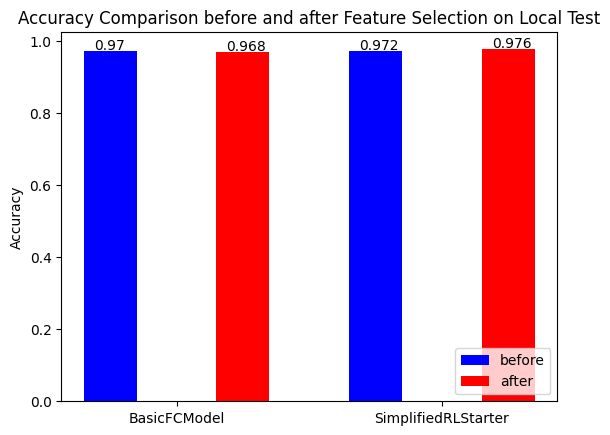

In [36]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
# ax2 = ax1.twinx() 
ax1.bar([0, 2],  [.97, .9717], width=.4, color='blue', label='before');
# ax1.bar([1, 3], [.1160, .1142], width=.4, color='green', label='after');
ax1.bar([1, 3], [0.9683, 0.9758], width=.4, color='red', label='after');
ax1.set_ylabel('Accuracy', color='black');
# ax1.tick_params(axis='y', labelcolor='orange');
# ax2.set_ylabel('Accuracy', color='b');
# ax2.tick_params(axis='y', labelcolor='b');
# ax1.set_xticks([0, 2], ['BasicFCModel', 'SimplifiedRLStarter'], rotation=5);
ax1.set_xticks([.5, 2.5], ['BasicFCModel', 'SimplifiedRLStarter']);
for ind, val in zip(range(4), [.97, 0.9683, .9717, 0.9758]):
    ax = ax1 #if ind % 2 == 0 else ax2
    h_add = .005 #if ind % 2 == 0 else .005
    ax.text(ind-.125, val+h_add, s=str(round(val, 3)))
plt.title('Accuracy Comparison before and after Feature Selection on Local Test');
plt.legend(loc=4)
plt.savefig('./extracted_features/acc_comparison.png', dpi=300)

In [39]:
fe_importance['SimplifiedRLStarter'][0].shape

(3765,)

In [26]:
fe_importance['BasicFCModel'][0][1463]

0.0

In [23]:
imp = fe_importance['BasicFCModel'][0]

np.sum(imp[np.argsort(imp)[::-1][:800]])

0.9992460058629061

In [11]:
np.nonzero(fe_importance['BasicFCModel'][0])

(array([   0,    1,    3, ..., 2346, 2348, 2349]),)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(np.asarray(fe_importance['BasicFCModel'][0])[np.nonzero(fe_importance['BasicFCModel'][0])[0]], bins=100)

In [14]:
importance_level = np.argsort(fe_importance['BasicFCModel'][0])[::-1][:np.count_nonzero(fe_importance['BasicFCModel'][0])]

In [15]:
np.asarray(fe_importance['BasicFCModel'][0])[importance_level]

array([9.43464973e-02, 7.12541787e-02, 6.02651122e-02, ...,
       2.85341630e-10, 1.57271242e-10, 1.38377875e-19])

In [35]:
np.nonzero(fe_importance['BasicFCModel'][0])[0]

array([   0,    1,    2, ..., 2346, 2348, 2349])

In [50]:
fe_imp_ind = {'BasicFCModel':2200, 'SimplifiedRLStarter':3200}

In [51]:
fe_importance_set = {}
for k, vs in fe_importance.items():
    imp = set(np.argsort(vs[0])[::-1][:fe_imp_ind[k]])
    for v in vs:
        valid_inds = np.argsort(v)[::-1][:fe_imp_ind[k]]
        imp = imp.intersection(valid_inds)
    fe_importance_set[k] = imp

In [52]:
for k, v in fe_importance_set.items():
    print(f'{k} - {len(v)}')

BasicFCModel - 795
SimplifiedRLStarter - 1081


In [40]:
for k, v in fe_importance_set.items():
    fe_importance_set[k] = list(v)

In [41]:
X_fe_reduced = {}
for k, v in X.items():
    X_fe_reduced[k] = np.asarray(v)[:, fe_importance_set[k]]
    print(X_fe_reduced[k].shape)

(118, 1878)
(120, 2466)


In [53]:
for k, v in fe_importance_set.items():
    fe_importance_set[k] = [int(l) for l in list(v)]

In [54]:
X_fe_reduced = {}
for k, v in X.items():
    X_fe_reduced[k] = np.asarray(v)[:, fe_importance_set[k]]
    print(X_fe_reduced[k].shape)

(118, 795)
(120, 1081)


In [58]:
import json
json.dump(fe_importance_set, open(os.path.join(OUTPUT_FILEDIR, 'fe_ind2.json'), 'w'))

In [57]:
for k, v in X_fe_reduced.items():
    cen, acc = bootstrap_performance(v, y[k], clf, n=50, test_size=.2)
    print(k, np.mean(cen), np.mean(acc))
    # fe_importance[k] = fe_rank

BasicFCModel 0.11665780598913689 0.9641666666666667
SimplifiedRLStarter 0.10297708796412654 0.9791666666666665


In [10]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.111, max_depth=2, min_samples_leaf=6, min_samples_split=16, subsample=.6, max_features=300)
# param={'max_depth': range(2, 9, 2), 'min_samples_leaf': range(2, 35, 4), 'min_samples_split': range(16, 65, 4), 'max_features': range(200, 411, 20), 'subsample': np.arange(.6, .91, .02)}
# param = {'learning_rate':np.arange(.05, .301, .05), 'n_estimators':range(100, 2001, 25)}
param = {'learning_rate':np.arange(.001, .301, .001), 'n_estimators':range(100, 3001, 25)}
# param = {'learning_rate':[.015, .03, .005, .01, .0025, .025, .003, .0015, .0005], 'n_estimators':[125, 63, 375, 187, 750, 75, 630, 1250, 3750]}
gsearch = GridSearchCV(estimator=clf, param_grid=param, scoring=['neg_log_loss', 'accuracy'], n_jobs=10, cv=5, refit=False);
gsearch.fit(X, y);

In [11]:
gsearch_result = pd.DataFrame(gsearch.cv_results_).sort_values(by=['rank_test_neg_log_loss', 'rank_test_accuracy'])
gsearch_result.to_csv(os.path.join(OUTPUT_FILEDIR, f'gsearch_result_{k}.csv'))

In [12]:
gsearch_result.head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,...,std_test_neg_log_loss,rank_test_neg_log_loss,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
3745,0.078553,0.000611,0.001505,0.000028,0.033,125,"{'learning_rate': 0.033, 'n_estimators': 125}",-0.341112,-0.549322,-0.706908,...,0.140328,1,0.888889,0.777778,0.444444,0.750,0.250,0.622222,0.237398,32209
8073,0.063099,0.001126,0.001582,0.000049,0.07,100,"{'learning_rate': 0.07, 'n_estimators': 100}",-0.356271,-0.657309,-0.693475,...,0.131424,2,0.888889,0.666667,0.666667,0.750,0.250,0.644444,0.213293,27848
12870,0.071993,0.008178,0.001946,0.000462,0.111,100,"{'learning_rate': 0.111, 'n_estimators': 100}",-0.228063,-0.557090,-0.718041,...,0.212997,3,0.888889,0.666667,0.666667,0.750,0.625,0.719444,0.093953,2464
5850,0.062990,0.000678,0.001561,0.000037,0.051,100,"{'learning_rate': 0.051000000000000004, 'n_est...",-0.352012,-0.573338,-0.721012,...,0.142894,4,0.888889,0.777778,0.666667,0.625,0.375,0.666667,0.172357,20042
5968,0.079375,0.001292,0.001526,0.000033,0.052,125,"{'learning_rate': 0.052000000000000005, 'n_est...",-0.273112,-0.569925,-0.681151,...,0.193816,5,0.888889,0.666667,0.666667,0.750,0.250,0.644444,0.213293,27848
7839,0.063560,0.001277,0.001533,0.000042,0.068,100,"{'learning_rate': 0.068, 'n_estimators': 100}",-0.273675,-0.567905,-0.705889,...,0.190345,6,1.000000,0.666667,0.666667,0.750,0.375,0.691667,0.200000,9553
3042,0.062784,0.000799,0.001521,0.000027,0.027,100,"{'learning_rate': 0.027000000000000003, 'n_est...",-0.462242,-0.584624,-0.601283,...,0.103198,7,0.888889,0.777778,0.666667,0.750,0.250,0.666667,0.220129,20042
3393,0.062645,0.000817,0.001481,0.000028,0.03,100,"{'learning_rate': 0.030000000000000002, 'n_est...",-0.405477,-0.606294,-0.640579,...,0.122382,8,0.888889,0.777778,0.666667,0.750,0.250,0.666667,0.220129,20042
4565,0.094876,0.001898,0.001575,0.000037,0.04,150,"{'learning_rate': 0.04, 'n_estimators': 150}",-0.285554,-0.617364,-0.692358,...,0.186864,9,1.000000,0.555556,0.666667,0.750,0.375,0.669444,0.207573,19652
1291,0.125181,0.002050,0.001607,0.000009,0.012,200,"{'learning_rate': 0.012, 'n_estimators': 200}",-0.468924,-0.609551,-0.642298,...,0.088974,10,0.888889,0.777778,0.666667,0.750,0.250,0.666667,0.220129,20042


In [13]:
gsearch_result['mean_test_accuracy']

3745     0.622222
8073     0.644444
12870    0.719444
5850     0.666667
5968     0.644444
           ...   
29586    0.619444
33249    0.650000
34539    0.700000
34500    0.630556
34179    0.652778
Name: mean_test_accuracy, Length: 35100, dtype: float64

In [14]:
gsearch_result['rank_test_accuracy']

3745     32209
8073     27848
12870     2464
5850     20042
5968     27848
         ...  
29586    32524
33249    24445
34539     3014
34500    28522
34179    21022
Name: rank_test_accuracy, Length: 35100, dtype: int32

In [15]:
gsearch_result['mean_test_neg_log_loss']

3745    -0.596133
8073    -0.608179
12870   -0.611247
5850    -0.614984
5968    -0.619903
           ...   
29586   -3.528528
33249   -3.534978
34539   -3.559429
34500   -3.560073
34179   -3.623068
Name: mean_test_neg_log_loss, Length: 35100, dtype: float64